In [8]:
# Uninstall problematic versions
!pip uninstall -y numpy opencv-python albumentations

# Install compatible versions
!pip install numpy==1.23.5 opencv-python==4.7.0.72 albumentations==1.3.0

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: albumentations 2.0.6
Uninstalling albumentations-2.0.6:
  Successfully uninstalled albumentations-2.0.6
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 55.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.2
    Uninstalling scikit-image-0.25.2:
      Successfully uninst

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, balanced_accuracy_score
from albumentations.pytorch import ToTensorV2
import albumentations as A
from PIL import Image

In [2]:
# ==== Step 1: Albumentations Transforms ====
#Creating a function of transformations to preprocess the images, the training dataset will undergo Albumentation as well, while the test dataset undergoes just the transformation to a 224,224 size normalized image
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

In [3]:
# ==== Step 2: Albumentations Dataset Wrapper ====
#Creating a wrapper function for the Dataset
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

In [4]:
# ==== Step 3: Base Model Class ====
#Creating a base class for the image classification task where we define the accuracy tests taking place on the Validation set
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        _, preds = torch.max(out, dim=1)
        return {
            'val_loss': loss.detach(),
            'preds': preds.cpu(),
            'labels': labels.cpu()
        }

    def validation_epoch_end(self, outputs):
        val_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(val_losses).mean().item()
        all_preds = torch.cat([x['preds'] for x in outputs])
        all_labels = torch.cat([x['labels'] for x in outputs])

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        kappa = cohen_kappa_score(all_labels, all_preds)
        bal_acc = balanced_accuracy_score(all_labels, all_preds)

        return {
            'val_loss': epoch_loss,
            'val_acc': acc,
            'val_f1': f1,
            'val_kappa': kappa,
            'val_bal_acc': bal_acc
        }

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], "
              f"Train Loss: {result['train_loss']:.4f}, "
              f"Val Loss: {result['val_loss']:.4f}, "
              f"Acc: {result['val_acc']:.4f}, "
              f"F1: {result['val_f1']:.4f}, "
              f"Kappa: {result['val_kappa']:.4f}, "
              f"Balanced Acc: {result['val_bal_acc']:.4f}")

In [5]:
# ==== Step 4: ViT Classifier ====
#Loading a ViT Classifier wiht pre-trained weights and adding a final layer to suit to the task in hand
class ViTClassifier(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        weights = ViT_B_16_Weights.DEFAULT
        self.model = vit_b_16(weights=weights)

        # Freeze feature extractor
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace classification head
        self.model.heads = nn.Linear(self.model.heads.head.in_features, num_classes)

    def forward(self, xb):
        return self.model(xb)

# ==== Step 5: Device Helpers ====
#Creating an auxilary function to set up for Cuda(gpu)/Cpu 
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# ==== Step 6: Training Utilities ====
#Defining the training function
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [6]:
# ==== Step 7: Load Dataset and Create Train/Test Split ====
#Importing dataset of 120 Species of dogs from kaggle, with over 9,000 image dataset to train on
import kagglehub
dataset_path = kagglehub.dataset_download('jessicali9530/stanford-dogs-dataset')
full_dataset = ImageFolder(dataset_path + '/images/Images')
all_labels = [sample[1] for sample in full_dataset.samples]

# Train/test split (stratified)
#Loading and spliting the dataset
#Due to no separate Test folder, the current dataset is split to test and train
#The train set get further divided into Train and Validation
train_indices, test_indices = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# ==== Step 8: Apply Stratified K-Fold on Training Set Only ====
device = get_default_device()
train_labels = [all_labels[i] for i in train_indices]

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [8]:
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_labels)), train_labels)):
    print(f"\n--- Fold {fold+1} ---")

    # Create Subsets from the original training subset
    fold_train_subset = Subset(train_dataset, train_idx)
    fold_val_subset = Subset(train_dataset, val_idx)

    # Albumentations Datasets
    train_ds = AlbumentationsDataset(fold_train_subset, transform=get_transforms(train=True))
    val_ds = AlbumentationsDataset(fold_val_subset, transform=get_transforms(train=False))
    test_ds = AlbumentationsDataset(test_dataset, transform=get_transforms(train=False))

    # DataLoaders
    train_loader = DeviceDataLoader(DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True), device)
    val_loader = DeviceDataLoader(DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True), device)
    test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True), device)

    # Model and Training
    model = to_device(ViTClassifier(num_classes=len(full_dataset.classes)), device)
    history = fit(epochs=10, lr=1e-3, model=model, train_loader=train_loader, val_loader=val_loader)

    # Optional: Evaluate on test set after final fold
    test_result = evaluate(model, test_loader)
    print(f"\nTest results after Fold {fold+1}: {test_result}")


--- Fold 1 ---
Epoch [0], Train Loss: 1.1875, Val Loss: 0.2741, Acc: 0.9320, F1: 0.9301, Kappa: 0.9314, Balanced Acc: 0.9301
Epoch [1], Train Loss: 0.2187, Val Loss: 0.2284, Acc: 0.9345, F1: 0.9331, Kappa: 0.9340, Balanced Acc: 0.9333
Epoch [2], Train Loss: 0.1579, Val Loss: 0.2161, Acc: 0.9389, F1: 0.9375, Kappa: 0.9384, Balanced Acc: 0.9375
Epoch [3], Train Loss: 0.1276, Val Loss: 0.2192, Acc: 0.9357, F1: 0.9339, Kappa: 0.9352, Balanced Acc: 0.9342
Epoch [4], Train Loss: 0.1024, Val Loss: 0.2226, Acc: 0.9317, F1: 0.9307, Kappa: 0.9311, Balanced Acc: 0.9308
Epoch [5], Train Loss: 0.0864, Val Loss: 0.2233, Acc: 0.9338, F1: 0.9323, Kappa: 0.9332, Balanced Acc: 0.9322
Epoch [6], Train Loss: 0.0789, Val Loss: 0.2291, Acc: 0.9302, F1: 0.9289, Kappa: 0.9296, Balanced Acc: 0.9292
Epoch [7], Train Loss: 0.0676, Val Loss: 0.2265, Acc: 0.9325, F1: 0.9313, Kappa: 0.9319, Balanced Acc: 0.9313
Epoch [8], Train Loss: 0.0599, Val Loss: 0.2268, Acc: 0.9311, F1: 0.9301, Kappa: 0.9305, Balanced Acc: 0

In [9]:
print("\n--- Final Evaluation on Held-Out Test Set ---")
final_test_result = evaluate(model, test_loader)

print(f"\nFinal Test Set Results:")
print(f"  Accuracy           : {final_test_result['val_acc']:.4f}")
print(f"  F1 Score (macro)   : {final_test_result['val_f1']:.4f}")
print(f"  Cohen’s Kappa      : {final_test_result['val_kappa']:.4f}")
print(f"  Balanced Accuracy  : {final_test_result['val_bal_acc']:.4f}")
print(f"  CrossEntropy Loss  : {final_test_result['val_loss']:.4f}")


--- Final Evaluation on Held-Out Test Set ---

Final Test Set Results:
  Accuracy           : 0.9337
  F1 Score (macro)   : 0.9311
  Cohen’s Kappa      : 0.9331
  Balanced Accuracy  : 0.9322
  CrossEntropy Loss  : 0.2084


In [11]:
#Saving and loading the weights of the final model
from google.colab import drive

drive.mount('/content/drive')

SAVE_PATH = "/content/drive/MyDrive/saved_models"
os.makedirs(SAVE_PATH, exist_ok=True)

model_save_path = os.path.join(SAVE_PATH, 'VissionTransformer.pth')

torch.save(model.state_dict(), model_save_path)

print(f"✅ Model weights saved to: {model_save_path}")

Mounted at /content/drive
✅ Model weights saved to: /content/drive/MyDrive/saved_models/VissionTransformer.pth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s 

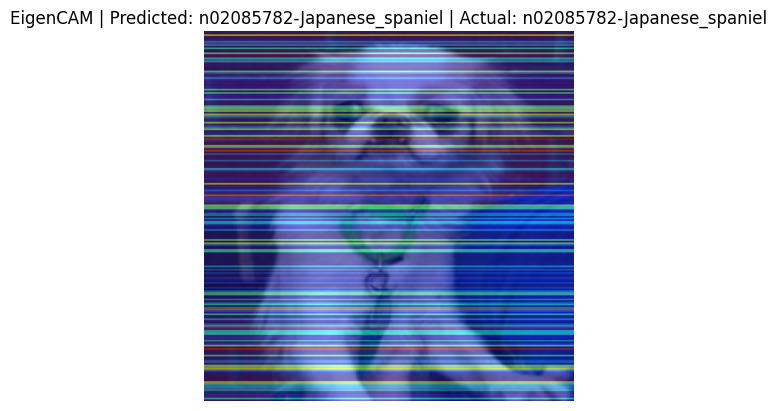

In [12]:
#The model trained above has shown a remarkable accuracy of about 92%, which is at par
#from that given by any other model, this can be attributed to teh advanced struture of the ViT Transformer.
#To get a deeper understanding of the model, let us look into the Grad-Cam image produced out of it.
#The image is not as teh usual one as the model does not specifically have support for grad-cam

!pip install grad-cam --quiet

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

index = 202  # Choose any index from the dataset
img_pil, actual_label = full_dataset[index]
img_np = np.array(img_pil)

val_transform = get_transforms(train=False)
input_tensor = val_transform(image=img_np)['image'].unsqueeze(0).to(device)

# Set Target Layer
# This works for torchvision ViT models.
target_layer = model.model.encoder.layers[-1].ln_2

# Initialize EigenCAM 
cam = EigenCAM(model=model, target_layers=[target_layer])

#Forward Pass and Prediction
model.eval()
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
targets = [ClassifierOutputTarget(pred_class)]

#Compute CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

#Overlay CAM on Original Image
resized_img = cv2.resize(img_np, (224, 224))
rgb_img = resized_img.astype(np.float32) / 255.0
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

predicted_label_name = full_dataset.classes[pred_class]
actual_label_name = full_dataset.classes[actual_label]

print(f"✅ Predicted Label: {predicted_label_name}")
print(f"🎯 Actual Label: {actual_label_name}")

plt.imshow(cam_image)
plt.title(f"EigenCAM | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=09a392d75899457ea0df0a93629ee1066908a8cba25155dc3f7dcc0fc06a4861
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

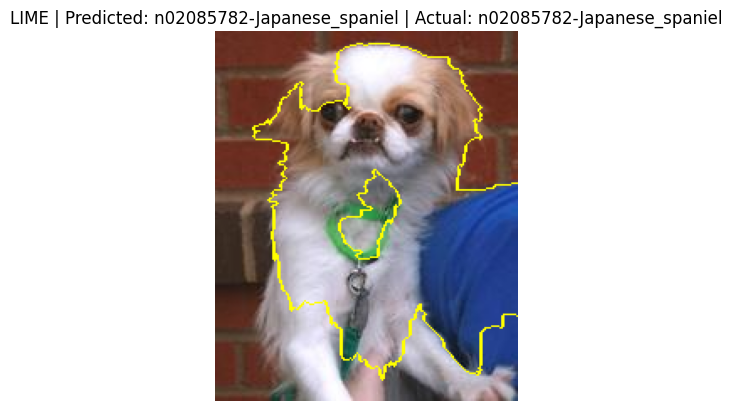

In [13]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

image_np, actual_label = full_dataset[202]
image_np = np.array(image_np)

#Define the classifier function for LIME
def batch_predict(images):
    model.eval()
    batch = torch.stack([
        val_transform(image=img)['image'] for img in images
    ]).to(device)
    logits = model(batch)
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    return probs

#Initialize and run LIME explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=image_np,
    classifier_fn=batch_predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000  # Increase for better stability
)

#Get LIME visualization for the predicted class
pred_class = batch_predict([image_np]).argmax()
lime_image_np, mask = explanation.get_image_and_mask(
    label=pred_class,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# Display LIME
predicted_label_name = full_dataset.classes[pred_class]
actual_label_name = full_dataset.classes[actual_label]

plt.imshow(mark_boundaries(lime_image_np, mask))
plt.title(f"LIME | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()
